# Filtering images with *PyDIP*
Here we show more of the nitty-gritty details of using the *PyDIP* functionality.

In [1]:
import diplib as dip

# let's keep the images small
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 72

DIPlib -- a quantitative image analysis library
Version 3.4.0 (Nov 30 2022)
For more information see https://diplib.org


After reading the "*PyDIP* basics" notebook, you should be familiar with the basics of running a *PyDIP* function:

In [2]:
img = dip.Image(dip.ImageRead('../erika.tif'))
smooth = dip.Gauss(img, 5)
print(img.DataType())
print(smooth.DataType())

UINT8
SFLOAT


is the same as:

In [3]:
smooth = dip.Image()
dip.Gauss(img, out=smooth, sigmas=5)
print(smooth.DataType())

SFLOAT


## The protect flag
The image passed as `out` argument will be reforged to have the right sizes, number of tensor elements, and data type, as dictated by the function producing the result. This is convenient, one does not need to worry about allocating the right size image to collect the output. However, this behavior makes the `out` argument not so useful, one gets the same effect using the syntax that returns the result.

The power of the `out` argument becomes aparent when one lears about [the protect flag](https://diplib.org/diplib-docs/dip-Image.html#protect)). This flag allows us to choose a data type for the output image. The filtering will be computed in the target data type, if appropriate, or otherwise its result will be cast to that type on the fly.

In [4]:
smooth = dip.Image()
smooth.SetDataType("UINT8")
smooth.Protect()
dip.Gauss(img, out=smooth, sigmas=5)
print(smooth.DataType())

UINT8


Note that the protected image was still given appropriate sizes by the `dip.Gauss()` function, we didn't need to set those manually. This is because the image `smooth` was raw (it had no data segment). That is, we created a raw image `smooth`, set its data type, and protected it. This signalled the filter that we wanted to use the given data type for this image.

The protect flag is also useful to apply a filter in place. Many filters can be computed without allocating an intermediate image (they'll allocate only small buffers, for example `dip.Gauss()` uses a buffer of the size of a single image line). 

In [5]:
print(img)
img.Protect()
dip.Gauss(img, out=img)
print(img)

2D Scalar image:
    data type:      UINT8
    sizes:          {256, 256}
    strides:        {1, 256}, tensor stride 1
    data pointer:   0x10898f730 (shared among 1 images)
    origin pointer: 0x140040000

2D Scalar image:
    data type:      UINT8
    sizes:          {256, 256}
    strides:        {1, 256}, tensor stride 1
    data pointer:   0x10898f730 (shared among 1 images)
    origin pointer: 0x140040000



Note how the "origin pointer" is not changed, the image uses the same memory before and after applying the filter.

Other filters will always need a separate image as output, when attempting to work in place, a copy of the input image is made.

## Working with color images
In the "PyDIP basics" notebook we've already seen that color images can be used normally with some functions, but some other functions work only on scalar images. Here we show various alternatives for working with these functions and color images. We'll use the `dip.Dilation()` function as an example.

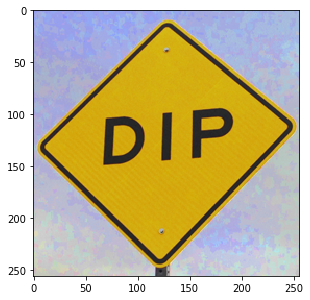

In [6]:
img = dip.Image(dip.ImageRead('../DIP.tif'))
img.Show()

In [7]:
se = dip.SE(25, "rectangular")
try:
    dip.Dilation(img, se=se)
except Exception as e:
    print(f"\033[31m{type(e).__name__} exception:", str(e).split('\n')[0])

RuntimeError exception: Image is not scalar


We cannot apply the `dip.Dilation()` function to a color image, the max value over a set of colors is not uniquely defined. But we can apply the function to one channel:

In [8]:
res = dip.Dilation(img(0), se=se)

We can also apply the function to each channel, using a simple loop:

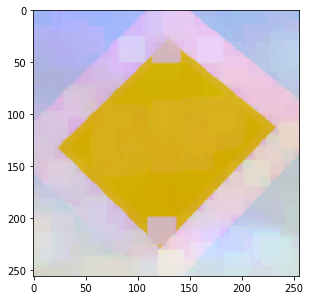

In [9]:
res = img.Similar()
for ii in range(img.TensorElements()):
    dip.Dilation(img(ii), out=res(ii), se=se)
res.Show()

This is called "marginal ordering", and can introduce new colors into the image.

An alternative, specifically for the dilation or erosion, is to use `dip.SelectionFilter()`, and create an image representing our own choice of ordering, for example based on the distance to pure yellow:

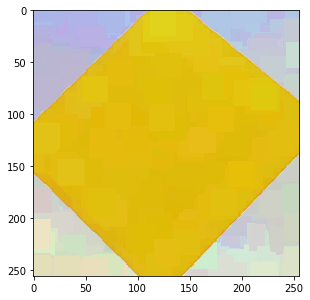

In [10]:
select = -dip.Norm(img - [255, 255, 0])
res = dip.SelectionFilter(img, select, kernel=dip.Kernel(25, "rectangular"), mode="maximum")
res.Show()